In [1]:
import numpy as np
import xarray as xr
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature
import pandas as pd
from sklearn.decomposition import pca
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from scipy import interpolate
import seaborn as sns

from MapXtremePCIC import MapXtremePCIC

%load_ext autoreload
%autoreload 2

In [5]:
PATH = './data/pr_24hr_50yrs/'

MapXtreme = MapXtremePCIC('110m', 'eof', PATH, 'pr')
data_cube = MapXtreme.read_data()

/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(8905,)


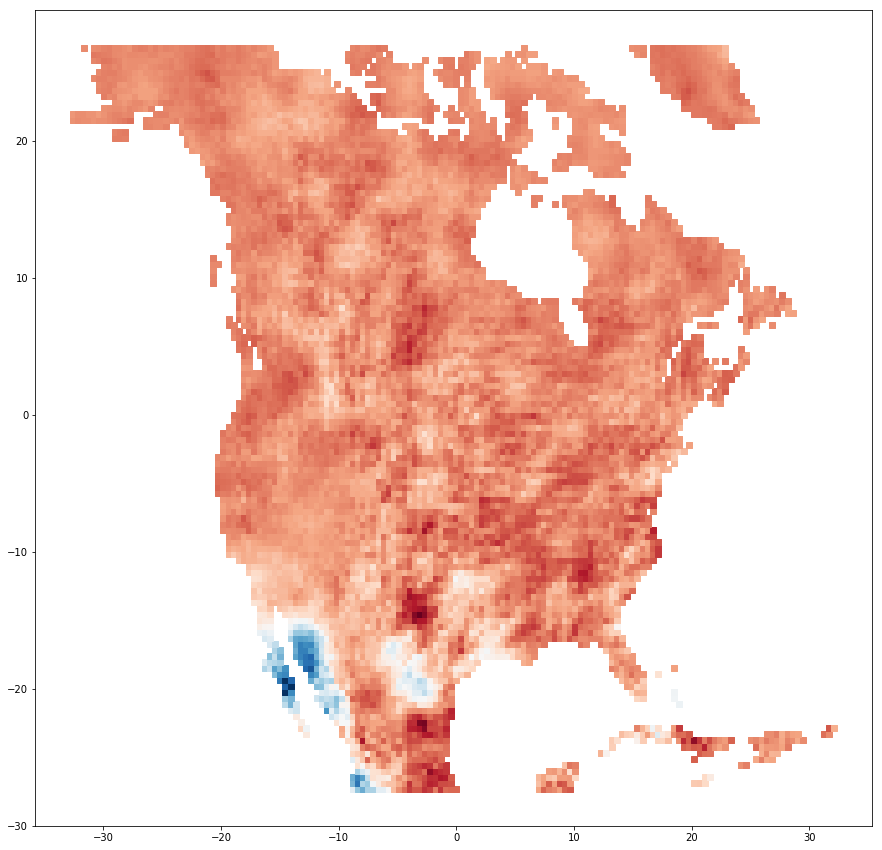

In [725]:
run_mean = data_cube['obs'].mean(dim='run', skipna=True)
X_mean = data_cube['obs'] - run_mean

p = data_cube['rlat'].shape[0]*data_cube['rlon'].shape[0]
n = data_cube['run'].shape[0]

rlat = np.sin(np.diff(data_cube['rlat']).mean())
rlon = np.diff(data_cube['rlon']).mean()

# calculate the differences along each axis to
# get grid cell size - shape is 1 smaller
# because the end point doesn't have a grid area.
lat_sz = np.abs(np.deg2rad(rlat))
lon_sz = np.abs(np.deg2rad(rlon))

# calculate rectangular area on sphere.
area = (lat_sz * lon_sz) * MapXtreme.R**2
total_area = area*p
frac_area = area/total_area

Y = data_cube['obs']*frac_area
X = X_mean*frac_area

X_ens = np.reshape(X.values, (p, n))
Y_ens = np.reshape(Y.values, (p, n))

is_land = ~np.isnan(X_ens)

frac = 0.02

# remove any ocean grid cells.
X_land = X_ens[is_land.any(axis=1)]
Y_land = Y_ens[is_land.any(axis=1)]

skpcao = pca.PCA()
skpcao.fit_transform(X_land.T) #_transform
EOFso = skpcao.components_.T[:, :1]

y_land = Y_land[:, 0]

print(y_land.shape)

# get fraction of results
index = np.random.choice(np.arange(y_land.shape[0]), int(frac*y_land.shape[0]))
y_sample = y_land[index]

X = EOFso[index, :]
y = y_sample

lm = linear_model.LinearRegression()
model = lm.fit(X, y)

score = model.score(X, y)

y_full_land = model.predict(EOFso)/frac_area
y_full_land

X_full = X_ens[:, 0]
X_full.shape
X_full[is_land[:, 0]] = y_full_land

data_cube['eofs'] = X_full#.reshape(data_cube['rlat'].shape[0], data_cube['rlon'].shape[0])

# set up repeating values of rlat, rlon times
rlat = np.repeat(data_cube['rlat'][:].values, data_cube['rlon'][:].shape[0])
# set up repeating sequence of rlon, rlat times
rlon = np.tile(data_cube['rlon'][:].values, data_cube['rlat'][:].shape[0])

plt.figure(figsize = (15, 15))
plt.scatter(rlon, rlat, c = data_cube['eofs'],  marker='s', cmap = plt.cm.RdBu)

In [387]:
is_land = np.isnan(X_ens)


land_slice = X_ens[~a, 0]

land = X_ens[~np.isnan(X_ens).any(axis=1)].T

y = np.empty(p)
y[:] = np.nan

frac = 0.2
print(land.shape)
index = np.random.choice(np.arange(land_slice.shape[0]), 
                         int(frac*land_slice.shape[0]))
y = y[~a_slice]
y[index] = X_ens[index, i]
y_g = y#[~a_slice]

print(y_g.shape)

skpcao = pca.PCA(0.95)
skpcao.fit_transform(land) #_transform
EOFso = skpcao.components_

remove_no_obs = np.isnan(y_g)

EOF_land = EOFso[:, ~remove_no_obs]

import statsmodels.api as sm
from sklearn import linear_model

print((y_g==np.nan).any())

X = EOF_land
y = y_g

lm = linear_model.LinearRegression()
model = lm.fit(X, y_g)

# Note the difference in argument order
#predictions = model.predict(X) # make the predictions by the model
#lm.score(X, y)

#full = skpcao.transform(X_full)
#df_combined.shape, EOFso.shape

#df_fit = pd.DataFrame(EOFso)
#df_fit['run_pseudo'] = df_combined[['run_pseudo']]
#df_fit_na = df_fit.dropna()
#df_fit_na
#EOFso_noobs = df_fit_na.loc[:, df_fit_na.columns != 'run_pseudo'].values
#EOF = df_fit.loc[:, df_fit.columns != 'run_pseudo'].values
#y_g = df_fit_na['run_pseudo'].values

#import statsmodels.api as sm
#from sklearn import linear_model

#X = EOFso_noobs
#y = y_g

#lm = linear_model.LinearRegression()
#model = lm.fit(X,y)

# Note the difference in argument order
#predictions = model.predict(X) # make the predictions by the model
#lm.score(X, y)

IndexError: too many indices for array

In [3]:
df_obs = MapXtreme.get_pseudo_obs()
df_model = MapXtreme.standard_matrix(MapXtreme.ensemble_mean(MapXtreme.get_df())).dropna()

In [16]:
df_obs.head()

,areas,rlat,rlon,run0,run1,run2,run3,run4,run5,run6,...,run26,run27,run28,run29,run30,run31,run32,run33,run34,run_pseudo
14420,2259.451955,15.400002,-4.400009,-0.000002,-0.000013,-0.000005,0.000021,-0.000008,0.000011,-0.000017,...,-0.000004,-5.029105e-06,1.512621e-05,-9.292734e-06,-0.000008,-0.000009,0.000012,0.000007,-0.000017,0.000013
14092,1867.255168,14.520001,-18.480011,-0.000004,0.000002,-0.000001,0.000011,0.000006,0.000002,-0.000001,...,-0.000001,5.747656e-06,1.104610e-05,-5.511094e-06,-0.000001,0.000002,0.000003,0.000002,-0.000001,-0.000010
12850,1873.457651,10.560001,21.119995,0.000008,0.000010,-0.000018,0.000002,0.000010,-0.000005,0.000010,...,0.000007,-1.150453e-06,-1.650612e-07,-6.520884e-06,0.000008,-0.000005,-0.000009,-0.000003,-0.000016,-0.000004
4645,2291.066790,-13.639997,-7.480011,-0.000022,-0.000007,-0.000004,0.000086,0.000014,-0.000012,-0.000008,...,0.000029,4.764404e-07,-2.607773e-06,-2.923440e-05,-0.000021,0.000066,0.000009,0.000038,0.000021,-0.000038
3755,2258.346824,-16.279999,-8.360016,0.000028,0.000021,-0.000012,0.000005,0.000016,0.000004,-0.000025,...,-0.000003,-1.270061e-05,-2.873268e-05,4.548968e-07,0.000034,0.000034,-0.000004,0.000016,-0.000013,0.000024


In [19]:
df_combined = MapXtreme.combine_model_obs(df_obs, df_model)
df_combined_dna = df_combined.dropna()
df_combined_dna.head()

,areas,rlat,rlon,run0,run1,run2,run3,run4,run5,run6,...,run28,run29,run30,run31,run32,run33,run34,run_pseudo,rlat_copy,rlon_copy
50,2107.018110,-26.839998,7.919998,0.000025,-0.000025,0.000055,0.000004,0.000003,-9.307944e-06,9.534188e-07,...,0.000027,-1.003586e-05,0.000030,-1.263691e-05,0.000004,0.000001,-0.000005,0.000027,-26.839998,7.919998
87,1964.667303,-26.399998,21.559998,0.000043,0.000021,-0.000038,0.000038,-0.000036,3.872957e-05,-2.649453e-05,...,-0.000048,-3.995781e-05,-0.000043,-2.548014e-07,-0.000012,-0.000005,0.000010,0.000034,-26.399998,21.559998
219,1900.033902,-24.199999,27.279999,0.000007,-0.000015,-0.000016,0.000012,0.000003,1.441720e-05,-1.640788e-05,...,-0.000003,6.730746e-07,0.000022,6.727431e-06,0.000009,-0.000026,-0.000013,0.000003,-24.199999,27.279999
394,2215.119872,-21.999998,-0.880005,0.000055,-0.000016,-0.000007,-0.000070,-0.000019,2.120021e-05,7.897912e-05,...,-0.000014,-5.031292e-06,0.000062,1.599693e-05,0.000016,0.000021,0.000010,0.000041,-21.999998,-0.880005
404,2192.055130,-21.559998,-8.360016,0.000010,-0.000019,-0.000044,0.000006,-0.000027,-2.222420e-07,9.585391e-06,...,0.000042,-1.497452e-05,0.000024,-1.819904e-05,-0.000009,0.000019,0.000020,0.000018,-21.559998,-8.360016


In [5]:
y_g = df_combined_dna['run_pseudo'].values

df_field = df_combined_dna.loc[:, df_combined_dna.columns != 'run_pseudo']

n_field, p_field, X_field = MapXtreme.get_arr(df_field)

In [6]:
df_field_full = df_combined.loc[:, df_combined.columns != 'run_pseudo']
n_full, p_full, X_full = MapXtreme.get_arr(df_field_full)
df_field_full.head()

,areas,rlat,rlon,run0,run1,run2,run3,run4,run5,run6,...,run27,run28,run29,run30,run31,run32,run33,run34,rlat_copy,rlon_copy
0,2095.101538,-27.279999,-8.800003,-0.000029,-0.000003,-0.000011,0.000105,-0.000045,-0.000063,-0.000051,...,0.000051,-0.000034,0.000048,0.000093,0.000055,-0.000045,0.000022,0.000009,NaN,NaN
1,2097.951178,-27.279999,-8.360016,-0.000069,-0.000034,0.000034,0.000145,-0.000033,-0.000050,-0.000059,...,0.000152,-0.000071,0.000052,0.000091,0.000037,-0.000063,-0.000032,0.000024,NaN,NaN
2,2100.735570,-27.279999,-7.919998,-0.000058,-0.000072,0.000137,0.000040,-0.000002,0.000014,-0.000093,...,0.000059,-0.000042,0.000052,0.000130,0.000035,-0.000059,-0.000044,0.000063,NaN,NaN
3,2103.285664,-27.279999,-7.480011,0.000001,-0.000057,0.000099,0.000046,-0.000010,-0.000007,-0.000029,...,0.000076,-0.000034,0.000121,0.000058,0.000039,-0.000036,-0.000062,0.000052,NaN,NaN
4,2105.743245,-27.279999,-7.039993,-0.000049,-0.000083,0.000003,0.000010,-0.000052,-0.000003,-0.000061,...,0.000022,0.000004,0.000086,0.000008,0.000102,0.000010,-0.000034,-0.000036,NaN,NaN


In [59]:
X_full.shape

(35, 8843)

In [70]:
skpcao = pca.PCA(0.95)
skpcao.fit_transform(X_full) #_transform
EOFso = skpcao.components_.T

#full = skpcao.transform(X_full)
df_combined.shape, EOFso.shape

df_fit = pd.DataFrame(EOFso)
df_fit['run_pseudo'] = df_combined[['run_pseudo']]
df_fit_na = df_fit.dropna()
df_fit_na
EOFso_noobs = df_fit_na.loc[:, df_fit_na.columns != 'run_pseudo'].values
EOF = df_fit.loc[:, df_fit.columns != 'run_pseudo'].values
y_g = df_fit_na['run_pseudo'].values

import statsmodels.api as sm
from sklearn import linear_model

X = EOFso_noobs
y = y_g

lm = linear_model.LinearRegression()
model = lm.fit(X,y)

# Note the difference in argument order
predictions = model.predict(X) # make the predictions by the model
lm.score(X, y)

0.7799501166866392

In [80]:
EOF.shape, EOFso_noobs.shape
# new values
y_g_new = model.predict(EOF)
df_combined['eofs'] = y_g_new
df_combined.head()
#MapXtreme.ensemble_mean(df_combined, reverse=True).head()

,areas,rlat,rlon,run0,run1,run2,run3,run4,run5,run6,...,run29,run30,run31,run32,run33,run34,run_pseudo,rlat_copy,rlon_copy,eofs
0,2095.101538,-27.279999,-8.800003,-0.000029,-0.000003,-0.000011,0.000105,-0.000045,-0.000063,-0.000051,...,0.000048,0.000093,0.000055,-0.000045,0.000022,0.000009,NaN,NaN,NaN,-0.000022
1,2097.951178,-27.279999,-8.360016,-0.000069,-0.000034,0.000034,0.000145,-0.000033,-0.000050,-0.000059,...,0.000052,0.000091,0.000037,-0.000063,-0.000032,0.000024,NaN,NaN,NaN,-0.000075
2,2100.735570,-27.279999,-7.919998,-0.000058,-0.000072,0.000137,0.000040,-0.000002,0.000014,-0.000093,...,0.000052,0.000130,0.000035,-0.000059,-0.000044,0.000063,NaN,NaN,NaN,-0.000104
3,2103.285664,-27.279999,-7.480011,0.000001,-0.000057,0.000099,0.000046,-0.000010,-0.000007,-0.000029,...,0.000121,0.000058,0.000039,-0.000036,-0.000062,0.000052,NaN,NaN,NaN,-0.000025
4,2105.743245,-27.279999,-7.039993,-0.000049,-0.000083,0.000003,0.000010,-0.000052,-0.000003,-0.000061,...,0.000086,0.000008,0.000102,0.000010,-0.000034,-0.000036,NaN,NaN,NaN,-0.000053


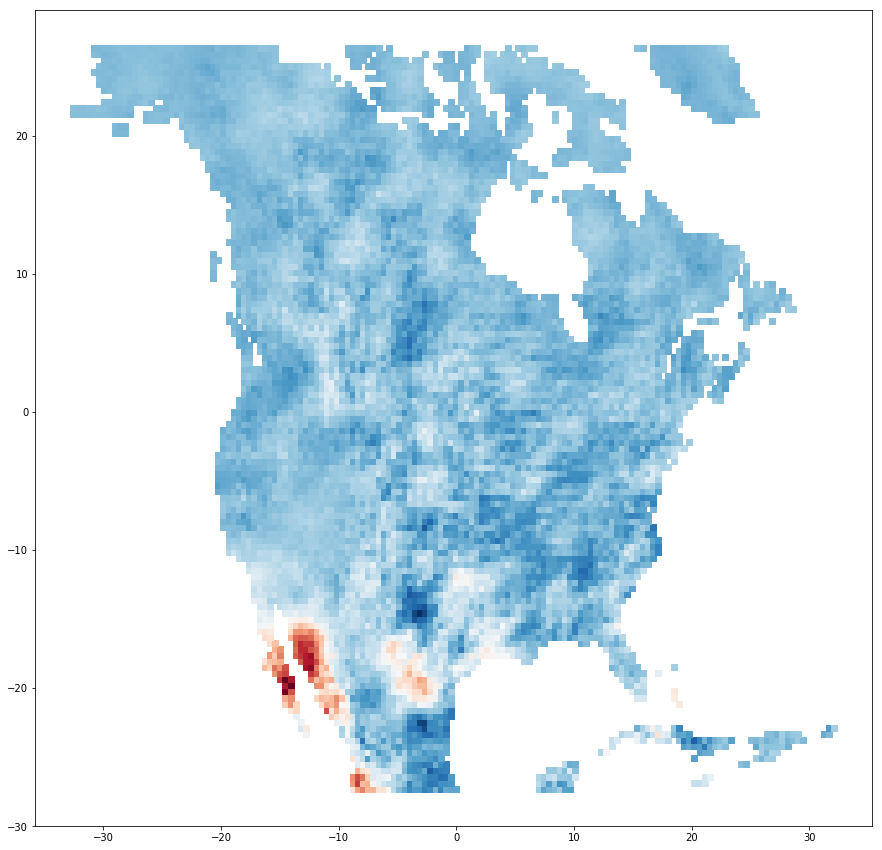

In [9]:
plt.figure(figsize = (15, 15))
plt.scatter(df_model['rlon'], df_model['rlat'], c = df_model['run_test_eof'],  marker='s', cmap = plt.cm.RdBu)

In [83]:
df_recon = MapXtreme.standard_matrix(df_combined, reverse = True)
#df_recon = df_recon[np.isfinite(df_recon['run_full_eof'])]
df_recon.head()

,areas,rlat,rlon,run0,run1,run2,run3,run4,run5,run6,...,run29,run30,run31,run32,run33,run34,run_pseudo,rlat_copy,rlon_copy,eofs
0,1772.265835,-27.279999,-32.560013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1780.387597,-27.279999,-32.119995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1788.304531,-27.279999,-31.679993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1796.161150,-27.279999,-31.239990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1804.299786,-27.279999,-30.800003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


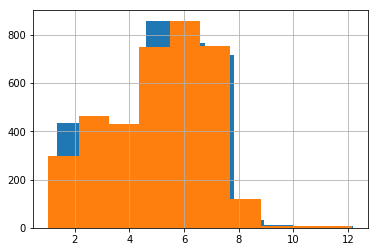

In [87]:
df_recon['eofs'].hist()
df_recon['run0'].hist()

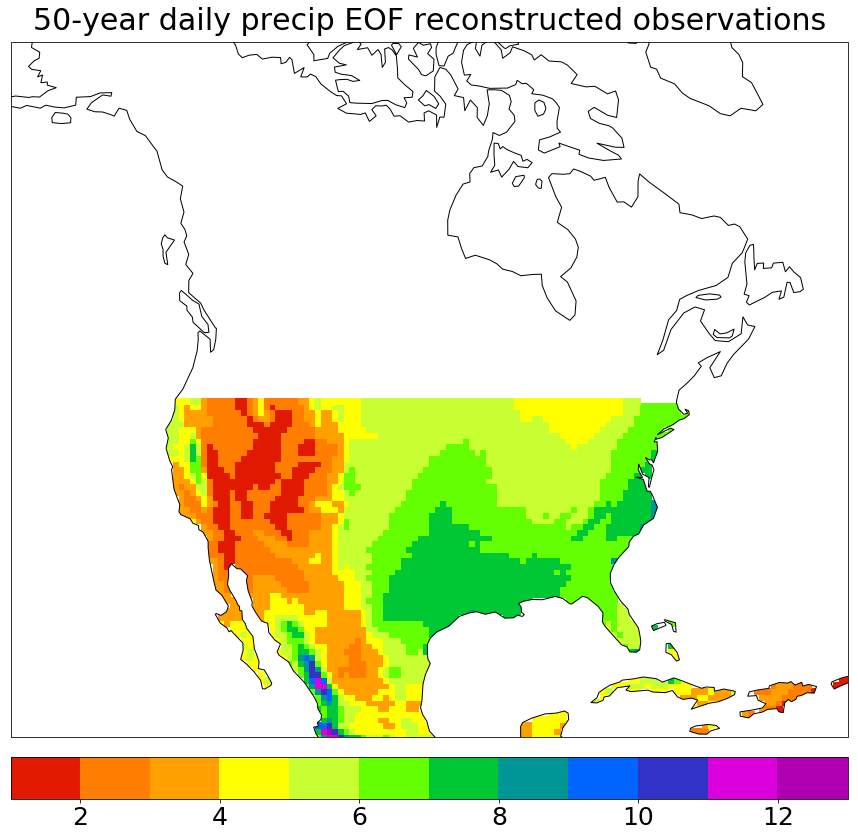

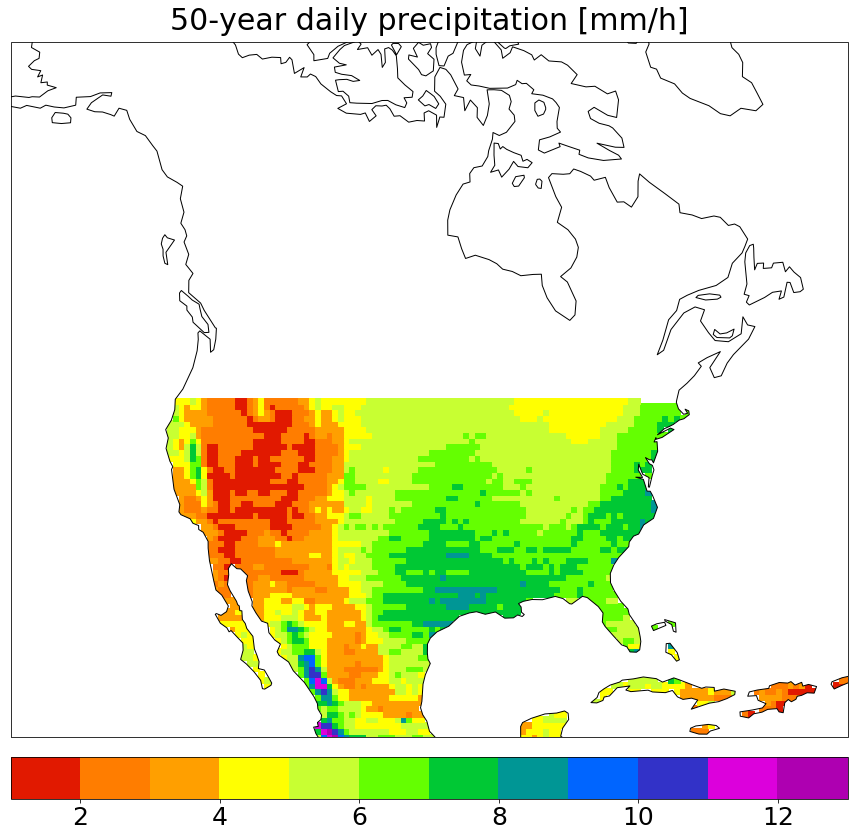

In [85]:
ax = MapXtreme.plot_reference(df = df_recon, run = 'eofs', plot_title='50-year daily precip EOF reconstructed observations', save_fig = True)

ax1 = MapXtreme.plot_reference(df = df_recon, run = 'run0', save_fig = True)

In [13]:
df = MapXtreme.get_df()
df = df.merge(df_recon, how = 'outer', on = ['rlat', 'rlon']).copy()

#df = pd.concat([MapXtreme.get_df(), df_recon], axis = 1).copy()

print(df.shape)

N_lon = 10*df['rlon'].unique().shape[0]
N_lat = 10*df['rlat'].unique().shape[0]

z = np.reshape(df['run_full_eof'].interpolate(method='nearest').fillna(0.0).values, (df['rlat'].unique().shape[0], df['rlon'].unique().shape[0]))

new_lon = np.linspace(df['rlon'].min(), df['rlon'].max(), N_lon)
new_lat = np.linspace(df['rlat'].min(), df['rlat'].max(), N_lat)

print(z.shape)

#interp
new_grid=interpolate.interp2d(df['rlon'].unique(), df['rlat'].unique(), z, kind = 'cubic')

(18204, 76)
(123, 148)


In [14]:
df_interp = pd.DataFrame()
df_interp['rlat'] = np.repeat(new_lat, N_lon)
df_interp['rlon'] = np.tile(new_lon, N_lat)

new_z = new_grid(new_lon, new_lat)
new_z.shape
df_interp['run_full_eof_interp'] = np.reshape(new_z, new_z.shape[0]*new_z.shape[1])

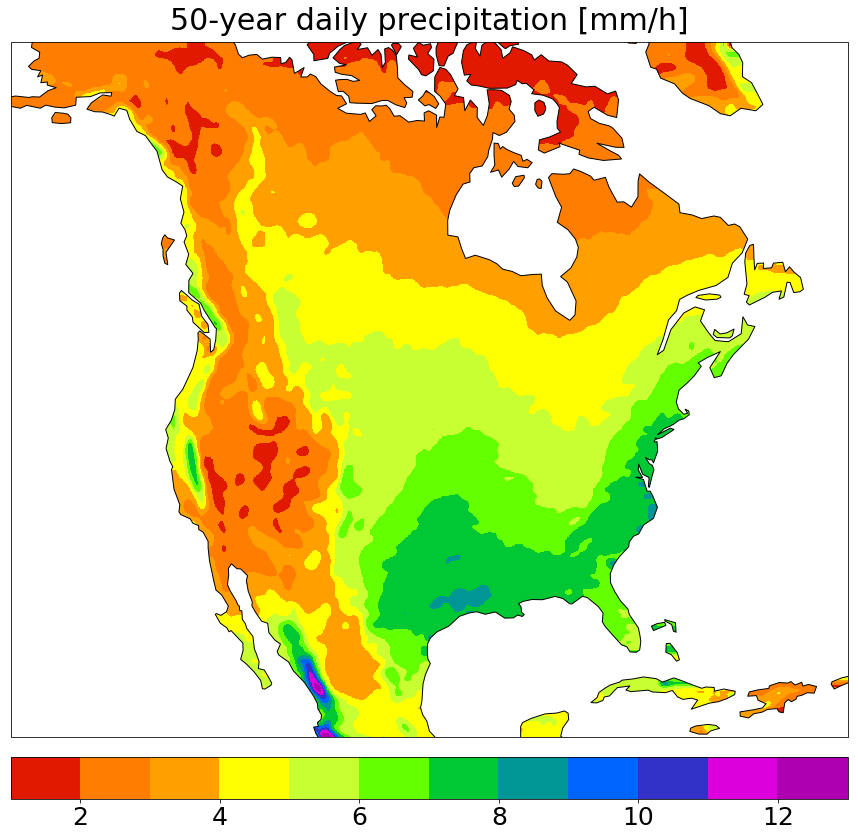

In [15]:
MapXtreme.plot_reference(df_interp, run = 'run_full_eof_interp', save_fig=True)

In [734]:
from datacube import read_data, DataReader
from operators import *
from eof import *

In [777]:
rd = DataReader(PATH)

In [778]:
ds = read_data(PATH)
ds['dv'].shape

(35, 124, 149)

In [782]:
cell_count(ds)

ds = read_data(PATH)
pred = eof_pseudo_full(ds)

pred

Model score: 0.9624160851111148


<xarray.DataArray (rlat: 124, rlon: 149)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan, 4.486765, ...,      nan,      nan,      nan]])
Coordinates:
  * rlon     (rlon) float64 -32.56 -32.12 -31.68 -31.24 ... 31.68 32.12 32.56
  * rlat     (rlat) float64 -27.28 -26.84 -26.4 -25.96 ... 25.96 26.4 26.84

(8905,) (8905,)
Model score: 0.9708426323366732


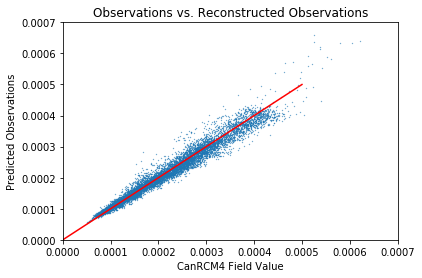

In [719]:
ds = read_data(PATH)

N = 35
# area weight the data
mean = ens_means(ds)
area = frac_grid_area(ds)

# unmasked area weighted
ensemble_obs = ensemble_reshape(ds*area)
mask = masked_nan(ds)

# masked and obs
masked_ens_obs = ensemble_obs[:, ~mask.mask]
obs = get_obs(masked_ens_obs)

ensemble_arr = ensemble_reshape(ds*area - mean)
masked_ensemble_arr = ensemble_arr[:N, ~mask.mask]
ens_eof = ensemble_to_eof(masked_ensemble_arr.T)[:, 0]
ens_eof.shape
print(ens_eof.shape, obs.shape)

obs_index = rand_sample_index(obs, 0.02)
obs_rand_sample = obs[obs_index]

model = regress_eof(ens_eof[obs_index], obs_rand_sample)
pred = predict_dv(model, ens_eof)

plt.scatter(obs, pred, marker='.', s=0.3)
plt.plot(np.linspace(-0.000, 0.0005, 10),
         np.linspace(-0.000, 0.0005, 10), 'r')
plt.xlim(0.0, 0.0007)
plt.ylim(0.0, 0.0007)
plt.title("Observations vs. Reconstructed Observations")
plt.xlabel("CanRCM4 Field Value")
plt.ylabel("Predicted Observations")
plt.savefig("plots/obs_reonstructed.pdf")

In [606]:
y = get_obs(ds)
ensemble = ensemble_reshape(ds)
ensemble.shape

AttributeError: 'Dataset' object has no attribute 'shape'

In [133]:
ensemble_eof = ensemble_to_eof(ensemble)

ens_cross_eof = ensemble_eof[index, :] 

model = regress_eof(ens_cross_eof, y)
predictions = predict_dv(model, ensemble_eof)

ds_eof = reconstruct_eof_full(predictions, ds)

(35, 124, 149)
(35, 124, 149)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<xarray.DataArray 'eofs' (eofs: 18476)>
array([     nan,      nan, 0.000278, ...,      nan,      nan, 0.000135])
Coordinates:
  * eofs     (eofs) float64 nan nan 0.0002782 nan ... nan nan 0.0001347

In [91]:
fit_transform(ds)

Model score: 0.6725304497264397


<xarray.Dataset>
Dimensions:  (eofs: 18476, rlat: 124, rlon: 149, run: 35)
Coordinates:
  * rlon     (rlon) float64 -32.56 -32.12 -31.68 -31.24 ... 31.68 32.12 32.56
  * rlat     (rlat) float64 -27.28 -26.84 -26.4 -25.96 ... 25.96 26.4 26.84
  * eofs     (eofs) float64 nan nan 9.58e-10 nan ... nan nan 4.373e-10
Dimensions without coordinates: run
Data variables:
    lon      (run, rlat, rlon) float64 233.5 233.8 234.2 ... 332.0 332.5 333.0
    lat      (run, rlat, rlon) float64 14.04 14.2 14.36 ... 59.87 59.56 59.26
    dv       (run, rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Author:        Chao Li @ PCIC - chaoli@uvic.ca
    Institution:   Pacific Climate Impacts Consortium
    Date created:  Tue Aug 28 00:13:00 2018

ValueError: x and y must be the same size

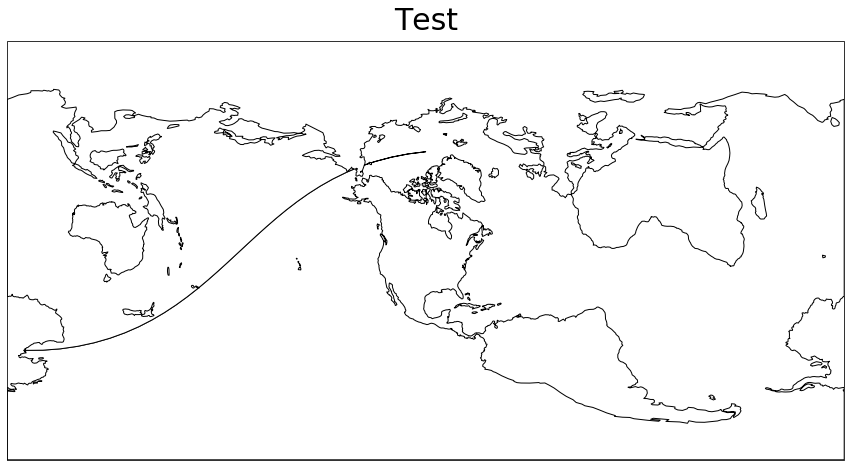

In [97]:
from mapper import *

plot_reference(ds, 'Test')